In [24]:
from classification import *
from trading import *
import numpy as np
import pandas as pd
import sqlite3
from sklearn.metrics import confusion_matrix
import plotly.express as px

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm


## Reading the Event Data and the Stock Data

In [25]:
# Connect to the SQLite database
conn = sqlite3.connect('final_data.db')

# Replace 'your_table' with the actual table name and 'conn' with your database connection
query = 'SELECT * FROM features_complete'

# Use the pandas read_sql function to read the data into a DataFrame
events_df = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Now, you can work with the DataFrame 'df'
events_df['date'] = pd.to_datetime(events_df['date'])
events_df = events_df.sort_values(by='date')
stock_df = pd.read_csv('stock_data.zip', compression='zip', header=[0, 1], index_col=0, parse_dates=True)


In [26]:
events_df.head()


,ticker,disease,stage,date,catalyst,NCAR,avg_5_10,avg_5_30,std_5_10,std_5_30,mkt_cap,roe,op_margin,net_margin,debt_ratio,20_day_pct_ret,bio_score,sec_score
0,PCRX,Postsurgical pain,Approved,2011-10-31,"Approved October 31, 2011.",-1.041054,0.370303,0.369892,-0.168146,-0.197195,4.356451e+08,0.008398,0.067019,0.010490,2.183010,-28.118609,0.633965,0.097330
1,INCY,Myelofibrosis,Approved,2011-11-16,"Approved November 16, 2011.",0.754430,-0.297576,-1.400215,-0.212675,-0.971217,2.858325e+09,0.086178,0.139470,0.117756,4.385141,3.709428,0.878714,0.067742
2,HALO,Overactive bladder,Approved,2011-12-08,"Approved December 8, 2011.",3.427405,0.291818,0.733871,-0.396335,-0.382197,1.283978e+09,1.018970,0.398417,0.325227,1.151618,2.302632,0.044723,0.126709
3,CRIS,Basal Cell Carcinoma,Approved,2012-01-30,"Approved January 30, 2012.",-2.355933,13.045455,39.500000,-2.882373,-11.948936,4.351435e+08,-0.243362,-3.540007,-3.924143,1.747271,-2.736842,0.516248,0.039100
4,CORT,Cushing's Syndrome,Approved,2012-02-17,"Approved February 17, 2012.",-0.955556,-0.210152,-0.388011,-0.144318,-0.129160,3.498192e+08,0.033080,0.218318,0.161087,7.150929,31.683168,0.115455,0.088730


## Preparing the Return Classes and Train and Test Sets

In [27]:
def scale_X(train_X, test_X, special_exclude_cols=['catalyst', 'date', 'ticker', 'stage', 'disease']):
    sc = MinMaxScaler()
    tmp_train = train_X.loc[:, ~train_X.columns.isin(special_exclude_cols)]
    tmp_cols = train_X.columns[~train_X.columns.isin(special_exclude_cols)]

    tmp_test = test_X.loc[:, ~test_X.columns.isin(special_exclude_cols)]

    train_features_scaled = sc.fit_transform(tmp_train)
    test_features_scaled = sc.transform(tmp_test)

    train_features_scaled_df = pd.DataFrame(train_features_scaled, columns = tmp_cols)
    X_train_scaled = pd.concat([train_features_scaled_df, train_X[special_exclude_cols].reset_index(drop=True)], axis=1)

    test_features_scaled_df = pd.DataFrame(test_features_scaled, columns = tmp_cols)
    X_test_scaled = pd.concat([test_features_scaled_df, test_X[special_exclude_cols].reset_index(drop=True)], axis=1)

    return X_train_scaled, X_test_scaled


In [32]:
# Data handling
target_col = 'NCAR'
exclude_cols = ['quintiles', 'NCAR']
test_size = 0.2
num_cuts = 3
dh = Data_Handler(events_df)
quintiles = dh.qcut_data(target_col, num_cuts)
dh.df['quintiles'] = quintiles
labels = [str(label) for label in quintiles.unique()].sort()
X_train, X_test, y_train, y_test = dh.train_test_split('quintiles', cols2exclude=exclude_cols, test_size=test_size)


In [33]:
X_train_scaled, X_test_scaled = scale_X(train_X=X_train, test_X=X_test)


# Transferring tabular data into graph

In [34]:
def create_graph(X, y):
    # Extract features and labels from the DataFrame
    feature_col = [i for i in X.columns if i not in exclude_cols + ['catalyst', 'date', 'ticker', 'stage', 'disease']]
    features = torch.tensor(X[feature_col].values, dtype=torch.float32)
    labels = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    # Map 'categorical' cols to indices
    # Create a DGL graph from edges and node features using vectorized operations
    catalyst_matrix = X['catalyst'].astype('category').cat.codes.values[:, None]
    ticker_matrix = X['ticker'].astype('category').cat.codes.values[:, None]
    disease_matrix = X['disease'].astype('category').cat.codes.values[:, None]
    stage_matrix = X['stage'].astype('category').cat.codes.values[:, None]
    date_matrix = pd.to_datetime(X['date']).values[:, None]

    # Create condition matrices
    ticker_condition = ticker_matrix == ticker_matrix.T
    date_condition = np.abs(date_matrix - date_matrix.T) < np.timedelta64(365, 'D')
    disease_condition = disease_matrix == disease_matrix.T
    stage_condition = stage_matrix == stage_matrix.T

    # Combine conditions to form the final condition matrix
    condition_matrix = np.logical_or(np.logical_and(ticker_condition, date_condition),
                                      np.logical_or(disease_condition, stage_condition))

    # Create edges between nodes based on shared 'ticker', 'date', 'disease', or 'stage'
    src_nodes, dst_nodes = np.where(condition_matrix & (catalyst_matrix != catalyst_matrix.T))

    src_nodes = torch.tensor(src_nodes, dtype=torch.long)
    dst_nodes = torch.tensor(dst_nodes, dtype=torch.long)

    g = dgl.graph((src_nodes, dst_nodes))
    g.ndata['features'] = features
    g.ndata['labels'] = labels

    return g


In [35]:
def plot_graph_network(g, filename):
    # Convert DGL graph to networkx graph
    nx_graph = g.to_networkx()

    # Visualize the networkx graph
    plt.figure(figsize=(16, 9))
    pos = nx.spring_layout(nx_graph)  # You can choose a different layout if needed
    nx.draw(nx_graph, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=8, font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5)

    # Display the plot
    plt.savefig(filename)
    plt.show()


In [36]:

# # Define a simple GCN model
# class GCN(nn.Module):
#     def __init__(input_dim, hidden_dim, output_dim):
#         super(GCN, self).__init__()
#         layer1 = dgl.nn.GraphConv(input_dim, hidden_dim)
#         layer2 = dgl.nn.GraphConv(hidden_dim, hidden_dim)
#         fc1 = nn.Linear(hidden_dim, hidden_dim)
#         fc2 = nn.Linear(hidden_dim, output_dim)

#     def forward(g, features):
#         x = F.linear(layer1(g, features))
#         x = F.linear(layer2(g, x))
#         x = F.linear(fc1(x))
#         x = fc2(x)
#         return x


In [37]:
# Convert data to DGL format
train_graph = create_graph(X=X_train_scaled, y=y_train)
test_graph = create_graph(X=X_test_scaled, y=y_test)
example10_graph = create_graph(X=X_train_scaled.head(10), y=y_train.head(10))
example100_graph = create_graph(X=X_train_scaled.head(100), y=y_train.head(100))


In [38]:
print(train_graph)
print(test_graph)
print(example10_graph)
print(example100_graph)


Graph(num_nodes=1832, num_edges=734224,
      ndata_schemes={'features': Scheme(shape=(12,), dtype=torch.float32), 'labels': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=459, num_edges=37300,
      ndata_schemes={'features': Scheme(shape=(12,), dtype=torch.float32), 'labels': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=10, num_edges=90,
      ndata_schemes={'features': Scheme(shape=(12,), dtype=torch.float32), 'labels': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
Graph(num_nodes=100, num_edges=5382,
      ndata_schemes={'features': Scheme(shape=(12,), dtype=torch.float32), 'labels': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})


In [39]:
# plot_graph_network(example10_graph, filename='./img/example_graph_10.png')


In [40]:
# plot_graph_network(example100_graph, filename='./img/example_graph_100.png')


In [66]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.layer1 = dgl.nn.GraphConv(input_dim, hidden_dim)
        self.layer2 = dgl.nn.GraphConv(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = F.relu(self.layer2(g, x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [42]:
# from torch_geometric.nn import ARMAConv
# class Net(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super().__init__()

#         self.conv1 = ARMAConv(in_channels, hidden_channels, num_stacks=3,
#                               num_layers=2, shared_weights=True, dropout=0.25)

#         self.conv2 = ARMAConv(hidden_channels, out_channels, num_stacks=3,
#                               num_layers=2, shared_weights=True, dropout=0.25,
#                               act=lambda x: x)

#     def forward(self, x, edge_index):
#         # x = F.dropout(x, training=self.training)
#         x = F.relu(self.conv1(x, edge_index))
#         # x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)


In [43]:
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
#     device = torch.device('mps')
# else:
#     device = torch.device('cpu')
# device


In [44]:
# #  Instantiate the model
# input_dim = X_train_scaled.shape[1] - 5  # Number of input features
# hidden_dim = 128
# output_dim = 1  # Binary classification

# model = Net(input_dim, hidden_dim, output_dim)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
# criterion = nn.BCEWithLogitsLoss()
# print(model)


In [67]:
#  Instantiate the model
input_dim = X_train_scaled.shape[1] - 5  # Number of input features
hidden_dim = 256
output_dim = 3  # Binary classification
# model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
model = GCN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
print(model)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


GCN(
  (layer1): GraphConv(in=12, out=256, normalization=both, activation=None)
  (layer2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [68]:
num_epochs = 1_000
losses = []

for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
    model.train()
    logits = model(train_graph, train_graph.ndata['features'])

    # Use the appropriate format for multi-class labels
    labels = torch.tensor(y_train.values, dtype=torch.long)  # Assuming y_train contains class indices

    # Calculate the loss using CrossEntropyLoss
    loss = criterion(logits, labels)

    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        tqdm.write(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')


Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Training:   0%|          | 2/1000 [00:00<03:33,  4.68epoch/s]

Epoch 1/1000, Loss: 1.0975428819656372


Training:  10%|█         | 101/1000 [00:19<02:57,  5.06epoch/s]

Epoch 101/1000, Loss: 1.091169834136963


Training:  20%|██        | 202/1000 [00:39<02:35,  5.12epoch/s]

Epoch 201/1000, Loss: 1.0774307250976562


Training:  30%|███       | 302/1000 [00:59<02:18,  5.04epoch/s]

Epoch 301/1000, Loss: 1.0767080783843994


Training:  40%|████      | 401/1000 [01:19<01:57,  5.08epoch/s]

Epoch 401/1000, Loss: 1.0761903524398804


Training:  50%|█████     | 502/1000 [01:39<01:38,  5.07epoch/s]

Epoch 501/1000, Loss: 1.0756944417953491


Training:  60%|██████    | 601/1000 [01:59<01:18,  5.07epoch/s]

Epoch 601/1000, Loss: 1.0751725435256958


Training:  70%|███████   | 702/1000 [02:19<00:58,  5.08epoch/s]

Epoch 701/1000, Loss: 1.07459557056427


Training:  80%|████████  | 802/1000 [02:38<00:39,  5.06epoch/s]

Epoch 801/1000, Loss: 1.074026346206665


Training:  90%|█████████ | 902/1000 [02:58<00:19,  5.00epoch/s]

Epoch 901/1000, Loss: 1.0735316276550293


Training: 100%|██████████| 1000/1000 [03:18<00:00,  5.05epoch/s]


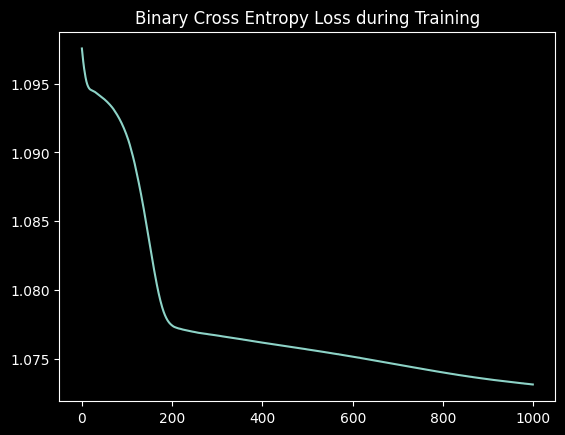

In [69]:
plt.plot(losses, label='Binary Cross Entropy Loss')
plt.title("Binary Cross Entropy Loss during Training")
plt.show()


In [70]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    try:
        test_logits = model(test_graph, test_graph.ndata['features'])
    except:
        test_graph_added_self_node = dgl.add_self_loop(test_graph)
        test_logits = model(test_graph_added_self_node, test_graph_added_self_node.ndata['features'])

    # For multi-class classification, use the argmax to get the predicted class
    predicted_labels = torch.argmax(test_logits, dim=1).numpy()

    # Optionally, you can calculate probabilities using softmax
    probabilities = F.softmax(test_logits, dim=1).numpy()


In [71]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_test, y_prob, y_pred, model_name):
   auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred, average='macro')
   recall = recall_score(y_test, y_pred, average='macro')
   f1 = f1_score(y_test, y_pred, average='macro')

   results = {
         'Model': model_name,
         'AUC': auc,
         'Accuracy': accuracy,
         'Precision': precision,
         'Recall': recall,
         'F1 Score': f1
   }

   return pd.Series(results)


In [72]:
print(calculate_metrics(y_test=y_test, y_prob=probabilities, y_pred=predicted_labels, model_name='GNN'))


Model             GNN
AUC          0.549473
Accuracy     0.457516
Precision    0.492673
Recall       0.405384
F1 Score     0.351246
dtype: object


In [73]:
probabilities


array([[0.4134119 , 0.47545913, 0.11112893],
       [0.41364008, 0.4752828 , 0.11107709],
       [0.37701857, 0.479281  , 0.14370042],
       ...,
       [0.4009957 , 0.31254253, 0.2864618 ],
       [0.3087994 , 0.23790863, 0.45329198],
       [0.38161188, 0.46806037, 0.15032777]], dtype=float32)

# Michele or anyone start working from here!

## Exploratory Analysis

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt


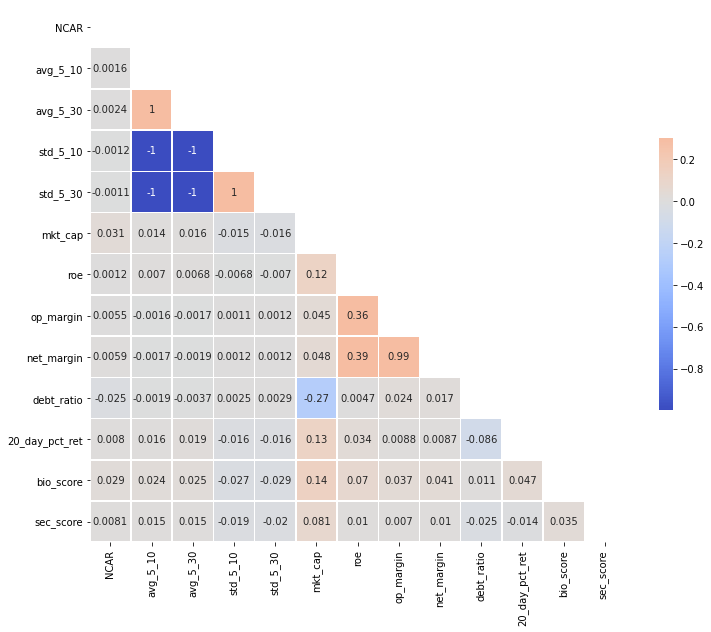

In [86]:
# Compute the correlation matrix
corr = events_df.iloc[:,5:-1].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

plt.show()


## Logistic Regression

In [79]:
# Create and fit the logistic regression model
model = LR()
model.train(X_train_scaled.iloc[:, :-5], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled.iloc[:, :-5])
y_prob = model.predict_prob(X_test_scaled.iloc[:, :-5])


/Users/Roy/anaconda3/envs/torch-gpu/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [84]:
print(calculate_metrics(y_test=y_test, y_prob=y_prob, y_pred=y_pred, model_name='Logistic Regression'))


Model        Logistic Regression
AUC                     0.569408
Accuracy                0.398693
Precision               0.419045
Recall                  0.384409
F1 Score                0.396596
dtype: object


In [85]:
# lr_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "Logistic Regression")
# model.results.print_confusion_matrix(y_test, y_pred, labels)
# model.results.plot_roc_curve(y_test, y_prob, "Logistic Regression")
# print(lr_fit_metrics)


In [7]:
trading_data = events_df.loc[X_test.index].reset_index(drop=True)
trading_data['lr_preds'] = y_pred
trading_data['lr_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
lr_portfolio = ts.buy_short('lr_signal', trading_data, stock_df, 20)


In [93]:
px.line(np.array(lr_portfolio))


## XGBoost

In [86]:
# Create and fit the XGBoost model
model = GB()
model.train(X_train_scaled.iloc[:, :-5], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled.iloc[:, :-5])
y_prob = model.predict_prob(X_test_scaled.iloc[:, :-5])


In [87]:
print(calculate_metrics(y_test=y_test, y_prob=y_prob, y_pred=y_pred, model_name='Logistic Regression'))


Model        Logistic Regression
AUC                      0.70894
Accuracy                0.540305
Precision               0.508769
Recall                  0.512145
F1 Score                0.508543
dtype: object


In [88]:
# gb_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "XGBoost Classifier")
# model.results.print_confusion_matrix(y_test, y_pred, labels)
# model.results.plot_roc_curve(y_test, y_prob, "XGBoost Classifier")
# print(gb_fit_metrics)


In [96]:
trading_data['gb_preds'] = y_pred
trading_data['gb_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
gb_portfolio = ts.buy_short('gb_signal', trading_data, stock_df, 20)


In [97]:
px.line(np.array(gb_portfolio))


## MLP Classifier

In [89]:
# Create and fit the Multi Layer Perceptron model
model = MLP()
model.train(X_train_scaled.iloc[:, :-5], y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled.iloc[:, :-5])
y_prob = model.predict_prob(X_test_scaled.iloc[:, :-5])


/Users/Roy/anaconda3/envs/torch-gpu/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [90]:
print(calculate_metrics(y_test=y_test, y_prob=y_prob, y_pred=y_pred, model_name='Logistic Regression'))


Model        Logistic Regression
AUC                     0.689261
Accuracy                0.481481
Precision               0.521092
Recall                  0.476846
F1 Score                0.475712
dtype: object


In [99]:
mlp_fit_metrics = model.results.calculate_metrics(y_test, y_prob, y_pred, "MLP Classifier")
model.results.print_confusion_matrix(y_test, y_pred, labels)
model.results.plot_roc_curve(y_test, y_prob, "MLP Classifier")
print(mlp_fit_metrics)


/Users/richi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Model        MLP Classifier
AUC                0.499185
Accuracy           0.284264
Precision          0.094755
Recall             0.333333
F1 Score           0.147563
dtype: object


In [100]:
trading_data['mlp_preds'] = y_pred
trading_data['mlp_signal'] = np.where(y_pred > 2, 1, np.where(y_pred < 2, -1, 0))
ts = Trading_Strategy()
mlp_portfolio = ts.buy_short('mlp_signal', trading_data, stock_df, 20)


In [101]:
px.line(np.array(mlp_portfolio))
